In [84]:
import os
import glob
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import datetime
from scipy.stats import norm, t

In [3]:
files = glob.glob('data/*.xlsx')
df = pd.read_excel(files[0], header=1)
# Limit to German market
df = df[(df['Market Area Buy']=='DE') & (df['Market Area Sell']=='DE')]
# Remove blocks
df = df[df['Hour from'] == df['Hour to']]
# Remove unnecessary items
df = df.drop(['Trade ID', 'Market Area Sell', 'Market Area Buy', 'Hour from'], axis=1)
# Rename to more sensible names
df = df.rename(columns={'Date':'date','Hour to':'to','Volume (MW)':'vol','Price (EUR)':'price','Time Stamp':'timestamp'})
df = df.set_index('timestamp')

df['weighted_price'] = df['vol'] * df['price']

We can cut out a section of the data to look at trends on smaller scales, eg. a single day. This is for two weeks

In [92]:
df_mini = df.loc[('2015-01-14'>df['date']) & (df['date']>='2015-01-01')].copy()
df_mini.head(1)

,date,to,vol,price,weighted_price
timestamp,,,,,
2014-12-31 15:17:00,2015-01-01,12,0.1,9.58,0.958


In [93]:
def qh_to_time(df):
    df['hour'] = pd.to_numeric(df['to'].apply(lambda s: s.split('qh')[0]))
    df['quarter'] = pd.to_numeric(df['to'].apply(lambda s: s.split('qh')[1]))
    return df

# Define quarterly and hourly dataframes
df_q = df_mini[df_mini['to'].str.contains('qh')].copy()
df_h = df_mini[~df_mini['to'].str.contains('qh')].copy()

df_q = qh_to_time(df_q)
df_h['to'] = pd.to_numeric(df_h['to'])

For now I'm slicing out quarter and hour trades as they are separate products

In [108]:
df_q.head(1)

,date,to,vol,price,weighted_price,hour,quarter
timestamp,,,,,,,
2014-12-31 16:01:00,2015-01-01,18qh1,20,24.2,484,18,1


In [110]:
df_h.head(1)

,date,to,vol,price,weighted_price
timestamp,,,,,
2014-12-31 15:17:00,2015-01-01,12,0.1,9.58,0.958


This is just a raw plot of the prices at trades. Not very informative but some larger trends are evident

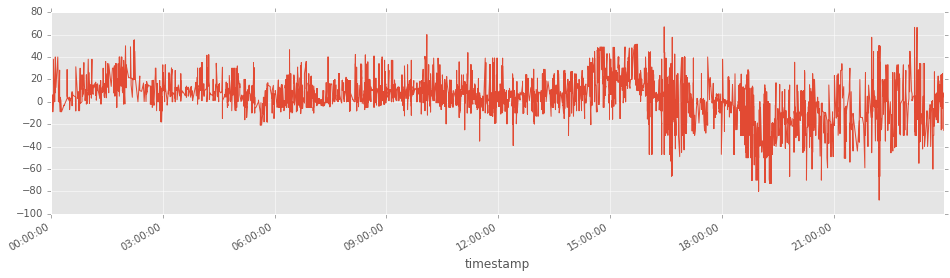

In [96]:
df_mini['price'].loc['2015-01-01'].plot(figsize=(16, 4));

For every hour of the day we can get the traded mean, std and sum (right y-axis). A lot of trading around 15 but very little around 19. Dinner time? This particular plot aggregate on hour of day so the day before at 16 is pooled with the hour today at 16. 

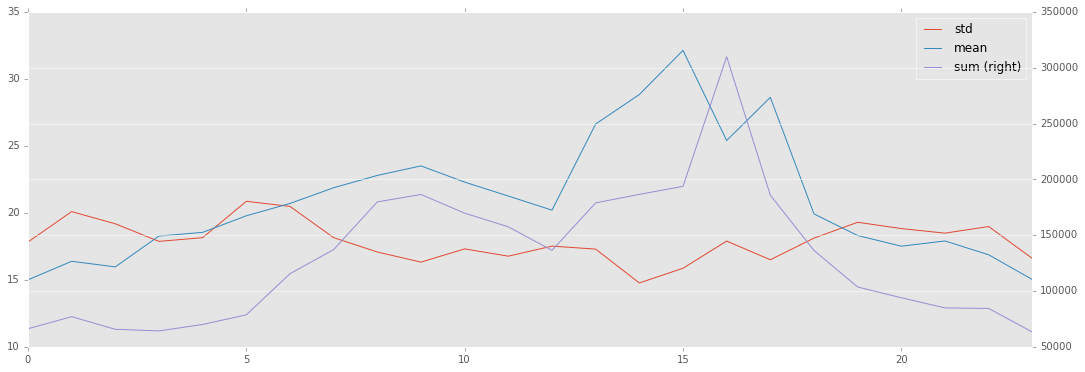

In [97]:
df_mini['price'].groupby(df_mini.index.hour).agg([np.std, np.mean, np.sum]).plot(figsize=(18,6), secondary_y='sum');

The distribution of the prices looks very normal but with some gaps, especially when you increase number of bins, probably because of rounding. Could look like a multimodal distribution. Surprisingly many negative/zero.

Mu: 21.758139, var: 18.356649


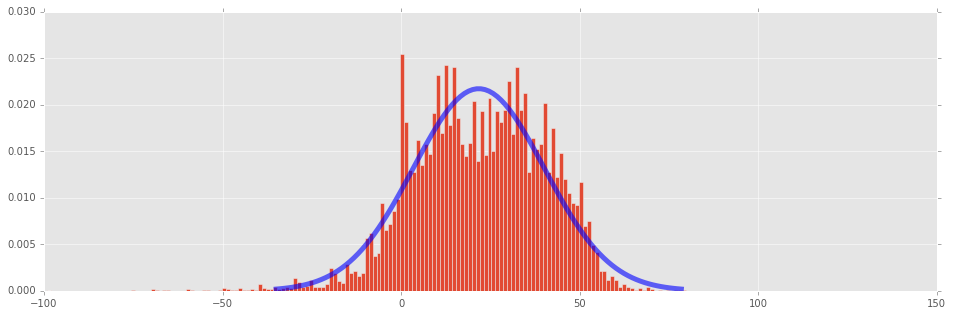

In [120]:
mu, sigma = norm.fit(df_mini['price'])
x = np.linspace(norm.ppf(0.001, mu, sigma), norm.ppf(0.999, mu, sigma), 100)
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(x, norm.pdf(x, mu, sigma), 'b-', lw=5, alpha=0.6)
ax.hist(df_mini['price'], bins=200, normed=True);
print('Mu: %f, var: %f' % (mu, sigma))

It is quite difficult to visualise when the individual hours are traded so here I just save a figure for each. 

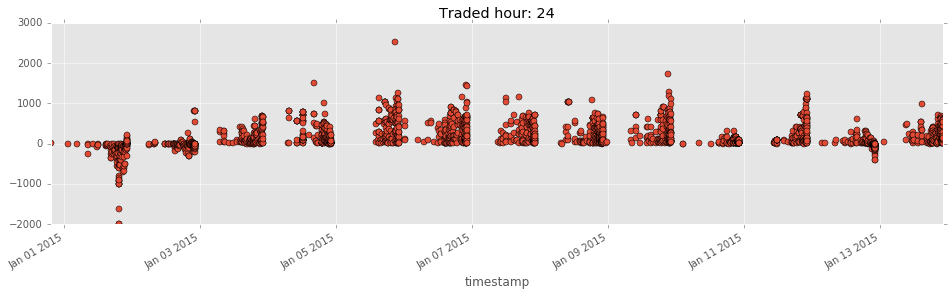

In [99]:
#df_h['period_index'] = df_h.index.to_perioddelta
for i in range(1, 25):
    plt.clf()
    df_h['weighted_price'].loc[df_h['to']==i].plot(figsize=(16, 4), title="Traded hour: %d" % i, marker='o', linewidth=0)
    plt.savefig('fig/weighted_price_%d.png' % i)

The following shows what hours that are most traded and at what price. Remember, this is not *when* but the hour the energy is used, i.e. the *product*.

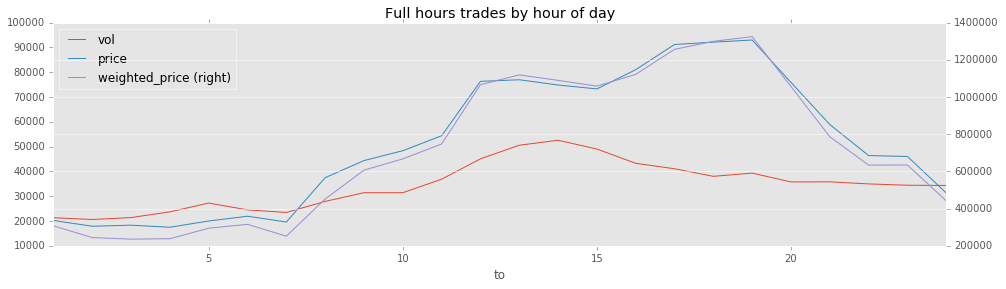

In [115]:
df_h[['vol', 'price', 'weighted_price', 'to']].groupby('to').sum().\
plot(figsize=(16, 4), secondary_y=['weighted_price'], title="Full hours trades by hour of day");

This plot shows what hours of the quarter hours that are most traded. Again the *product* is on the x-axis

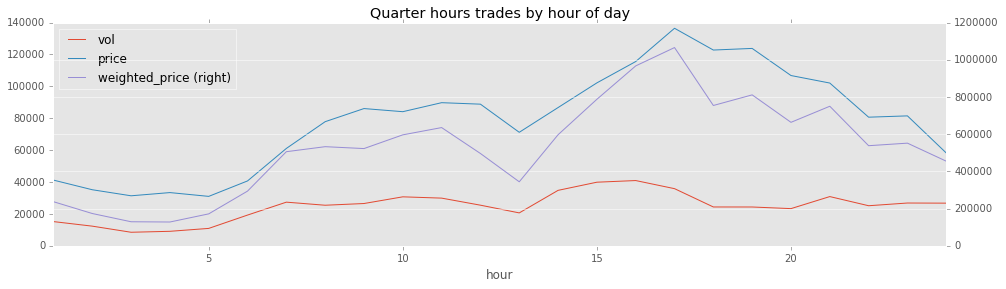

In [116]:
df_q[['vol', 'price', 'weighted_price', 'hour']].groupby('hour').sum().\
plot(figsize=(16,4), secondary_y=['weighted_price'], title="Quarter hours trades by hour of day");

This summarises the quarters. Quite interesting to see that the first and last quarter trades for a higher price

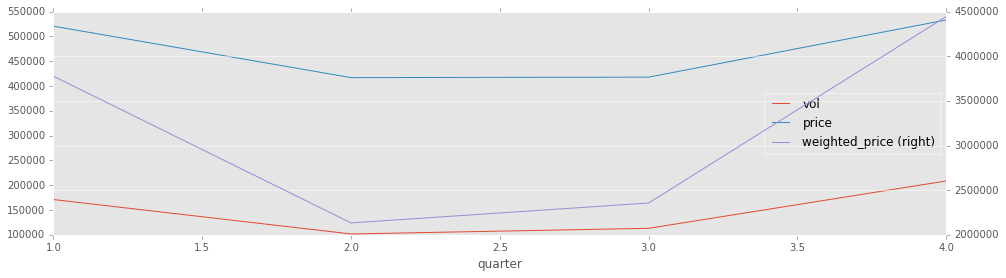

In [118]:
df_q[['vol', 'price', 'weighted_price', 'quarter']].groupby('quarter').sum().\
plot(figsize=(16, 4), secondary_y=['weighted_price']);